In [22]:
import spkit as sp
import numpy as np
import pandas as pd
import seaborn as sn
import os
import matplotlib.pyplot as plt
%matplotlib inline  
import mne
from copy import deepcopy
from mne.preprocessing import compute_proj_ecg
from mne_connectivity import envelope_correlation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
from mne.preprocessing import annotate_amplitude
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.signal import welch, coherence
from scipy.stats import entropy, skew, kurtosis
import networkx as nx
import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#import tsfresh
#from tsfresh import extract_features
#from tsfresh.feature_extraction import ComprehensiveFCParameters
#from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
import pyrqa
import mne
from mne.decoding import CSP
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pywt
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torchvision.models import mobilenet_v2
from torchvision import transforms
import cv2
from ordpy import renyi_entropy
import joblib
from sklearn.metrics import confusion_matrix
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score, precision_score, multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [2]:
import logging
logging.getLogger('mne').setLevel(logging.WARNING)

In [3]:
class FPG_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths, self.labels = self._load_filepaths_and_labels()

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        filepath = self.filepaths[index]
        label = self.labels[index]

        eeg_data = self._load_eeg(filepath)

        if self.transform is not None:
            eeg_data = self.transform(eeg_data)

        return torch.tensor(eeg_data), torch.tensor(label)

    def _load_filepaths_and_labels(self):
        filepaths = []
        labels = []

        classes = sorted(os.listdir(self.root_dir))
        for class_index, class_name in enumerate(classes):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                filenames = os.listdir(class_dir)
                for filename in filenames:
                    filepaths.append(os.path.join(class_dir, filename))
                    labels.append(class_index)

        return filepaths, labels

    def _load_eeg(self, filepath):
        data = mne.read_epochs(filepath, preload=False).get_data(picks='eeg');
        normals = []
        scaler = StandardScaler()
        for idx in range(len(data)):
            normals.append(scaler.fit_transform(data[idx]))

        return np.array(normals)

In [4]:
def custom_collate_fn(batch):
    # Concatenate data samples along the first dimension (window_count)
    # Assumes each sample is a tuple (uid, data_sample)
    uids, data_samples = zip(*batch)
    concatenated_data = torch.stack(data_samples, dim=0)
    return uids, concatenated_data

In [5]:
def PLV_(sample, verbose=False):
        
        EEG_data = sample[0]
        threshold = 0.3
        G = nx.Graph()

        # Add nodes (brain regions)
        G.add_nodes_from(range(21))  # Assuming 21 brain regions

        # Add edges (based on functional connectivity)
        for i in range(21):
            for j in range(i + 1, 21):
                # Calculate functional connectivity strength between nodes i and j
                # (e.g., using correlation coefficients from EEG signals)

                #phase locking value
                connectivity_strength = np.abs(np.mean(np.exp(1j * np.angle(EEG_data[i] * np.conj(EEG_data[j])))))  # Replace with actual method

                if connectivity_strength > threshold:
                    G.add_edge(i, j, weight=connectivity_strength)

        # Calculate graph metrics
        local_efficiency = nx.local_efficiency(G)
        global_efficiency = nx.global_efficiency(G)

        if (verbose):
                
            print(f"Local efficiency: {local_efficiency}")
            print(f"Global efficiency: {global_efficiency}")

        return local_efficiency, global_efficiency

In [6]:
def RQA(data_points, dimension):
    time_series = TimeSeries(data_points,
                         embedding_dimension = int(dimension),
                         time_delay =2)
    settings = Settings(time_series,
                    analysis_type=Classic,
                    neighbourhood=FixedRadius(0.1),
                    similarity_measure=EuclideanMetric,
                    theiler_corrector=1)
    computation = RQAComputation.create(settings,
                                    verbose=False)
    result = computation.run()
    rqa_features = [
        result.recurrence_rate,
        result.determinism,
        result.divergence,
        result.entropy_diagonal_lines,
        result.laminarity,
        result.trapping_time,
        result.entropy_vertical_lines,
        result.entropy_white_vertical_lines,
    ]
    
    return np.array(rqa_features)

In [7]:
def extract_wavelet_features(signal, wavelet_name, level):
    coeffs = pywt.wavedec(signal, wavelet_name, level=level)
    features = []
    for coeff in coeffs:
        features.extend([np.mean(coeff), np.std(coeff)])
    return features

In [8]:
def shannon_entropy(signal):
    # Compute probability distribution
    unique_values, counts = np.unique(signal, return_counts=True)
    probabilities = counts / len(signal)

    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    return entropy

In [9]:
def Score(y_pred, y_true):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    #roc_auc = roc_auc_score(y_true, ovr_classifier.predict_proba(X_test_combined), multi_class='ovr')


    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    #print(f"ROC AUC: {roc_auc:.4f}")

    matrix = confusion_matrix(y_true, y_pred)

    # Calculate balanced accuracy for each class
    class_balanced_acc = matrix.diagonal() / matrix.sum(axis=1)

    # Print the results
    for i, acc in enumerate(class_balanced_acc):
        if i == 0:
            print(f"Class FOCAL: Balanced Accuracy = {acc:.4f}")
        elif i == 1:
            print(f"Class IGE: Balanced Accuracy = {acc:.4f}")
        else:
            print(f"Class PNES: Balanced Accuracy = {acc:.4f}")


    
    # Assuming you have true labels (y_true) and predicted labels (y_pred)
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # Calculate true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN)
    tps = mcm[:, 1, 1]
    tns = mcm[:, 0, 0]

    # Calculate sensitivity (recall) for each class
    sensitivity = tps / (tps + mcm[:, 1, 0])

    # Calculate specificity for each class
    specificity = tns / (tns + mcm[:, 0, 1])

    # Print the results
    #for i, (sens, spec) in enumerate(zip(sensitivity, specificity)):
        #print(f"Class {i}: Sensitivity (Recall) = {sens:.4f}, Specificity = {spec:.4f}")


    matrix = multilabel_confusion_matrix(y_true, y_pred)

    # Calculate true negatives (TN) for each class
    tns = matrix[:, 0, 0]

    # Calculate false positives (FP) for each class
    fps = matrix[:, 0, 1]

    # Calculate specificity for each class
    specificity = tns / (tns + fps)

    # Calculate average specificity
    avg_specificity = specificity.mean()

    print(f"avg_specificity: {avg_specificity}")

In [10]:
def PLV(eeg_data):
    PLVs = []
    for channel in range(eeg_data.shape[0]):
        if(channel!=20):
            #print(channel)
            plv = np.abs(np.mean(np.exp(1j * np.angle(eeg_data[channel] * np.conj(eeg_data[channel + 1])))))
            PLVs.append(plv)
        
    PLVs.append(np.abs(np.mean(np.exp(1j * np.angle(eeg_data[20] * np.conj(eeg_data[0]))))))
    return np.array(PLVs).reshape(21, -1)


In [11]:
def coherence_features(eeg_data):
    vals = []
    for channel in range(eeg_data.shape[0]):
        if(channel!=20):
            #print(channel)
            f, Cxy = coherence(eeg_data[channel], eeg_data[channel + 1], fs=300, nperseg=300)
            vals.append(np.mean(Cxy))
        
    f, Cxy = coherence(eeg_data[20], eeg_data[0], fs=300, nperseg=300)
    vals.append(np.mean(Cxy))
    return np.array(vals).reshape(21, -1)


In [12]:
def extract_eeg_features(eeg_data, wavelet_type = 'db4', wavelet_level = 4, include_rqa = False):
    eeg_data = np.array(eeg_data)
    num_channels = eeg_data.shape[0]

    # Initialize arrays to store features
    mean_values = np.zeros(num_channels)
    std_values = np.zeros(num_channels)
    min_values = np.zeros(num_channels)
    max_values = np.zeros(num_channels)
    skewness_values = np.zeros(num_channels)
    kurtosis_values = np.zeros(num_channels)
    p2p_values = np.zeros(num_channels)
    p2rms_values = np.zeros(num_channels)
    rss_values = np.zeros(num_channels)
    amplitude = np.zeros(num_channels)
    rms = np.zeros(num_channels)
    zero_crossing_rate = np.zeros(num_channels)
    delta_power = np.zeros(num_channels)
    theta_power = np.zeros(num_channels)
    alpha_power = np.zeros(num_channels)
    beta_power = np.zeros(num_channels)
    gamma_power = np.zeros(num_channels)
    spectral_entropy = np.zeros(num_channels)
    shannon_ent = np.zeros(num_channels)
    renyi_ent = np.zeros(num_channels)
    rqa_matrix = []

    sym_wavelet_features = []
    for channel in eeg_data:
        channel_features = extract_wavelet_features(channel, 'sym5', level=4)
        sym_wavelet_features.append(channel_features)


    legend = []

    for channel in range(num_channels):
        # Extract data for the current channel
        channel_data = eeg_data[channel]

        # Compute mean, STD, min, max
        mean_values[channel] = np.mean(channel_data)
        std_values[channel] = np.std(channel_data)
        min_values[channel] = np.min(channel_data)
        max_values[channel] = np.max(channel_data)

        # Compute skewness and kurtosis
        skewness_values[channel] = skew(channel_data)
        kurtosis_values[channel] = kurtosis(channel_data)

        # Compute peak-to-peak (P2P)
        p2p_values[channel] = max_values[channel] - min_values[channel]

        # Compute peak-to-root sum square (P2RMS)
        p2rms_values[channel] = np.sqrt(np.sum(channel_data**2))

        # Compute root sum square (RSS)
        rss_values[channel] = np.sqrt(np.sum(channel_data**2))

        # Compute amplitude (peak-to-peak divided by 2)
        amplitude[channel] = p2p_values[channel] / 2

        # Compute root mean square (RMS)
        rms[channel] = np.sqrt(np.mean(channel_data**2))

        # Compute zero-crossing rate
        zero_crossing_rate[channel] = np.mean(np.diff(np.sign(channel_data)) != 0)

        # Compute power spectral density using Welch method
        f, psd = welch(channel_data, fs=1000, nperseg=256)
        delta_power[channel] = np.sum(psd[(f >= 1) & (f <= 4)])
        theta_power[channel] = np.sum(psd[(f >= 4) & (f <= 8)])
        alpha_power[channel] = np.sum(psd[(f >= 8) & (f <= 14)])
        beta_power[channel] = np.sum(psd[(f >= 14) & (f <= 30)])
        gamma_power[channel] = np.sum(psd[f > 30])
        if(include_rqa):
            rqa_matrix.append(RQA(channel_data, dimension=4))

        # Compute spectral entropy
        spectral_entropy[channel] = -np.sum(psd * np.log2(psd))
        #shannon_ent[channel] = shannon_entropy(channel_data)
        #renyi_ent[channel] = renyi_entropy(channel_data, 3)

        legend.append(["mean_values" + str(channel), "std_values" + str(channel), "min_values" + str(channel), "max_values" + str(channel),
                        "skewness_values" + str(channel), "kurtosis_values" + str(channel), "p2p_values" + str(channel), "p2rms_values" + str(channel),
                            "rss_values" + str(channel), "amplitude" + str(channel), "rms" + str(channel), "zero_crossing_rate" + str(channel)
                            , "delta_power" + str(channel),"theta_power" + str(channel), "alpha_power" + str(channel),
                            "beta_power" + str(channel), "gamma_power" + str(channel), "mean_app_lvl1_" + str(channel), "std_app_lvl1_" + str(channel),
                            "mean_detail_lvl1_" + str(channel), "std_detail_lvl1_" + str(channel), "mean_app_lvl2_" + str(channel), "std_app_lvl2_" + str(channel),
                            "mean_detail_lvl2_" + str(channel), "std_detail_lvl2_" + str(channel), "mean_app_lvl3_" + str(channel), "std_app_lvl3_" + str(channel)])
    



        
    
       

    # Organize features into a dictionary
    features = np.array([mean_values, std_values, min_values, max_values, skewness_values, kurtosis_values,
                         p2p_values, p2rms_values, rss_values,amplitude, rms, zero_crossing_rate,delta_power,
                         theta_power, alpha_power, beta_power, gamma_power]).T
    if(include_rqa):
        features = np.append(features, np.array(rqa_matrix), axis=1)

    features = np.append(features, sym_wavelet_features, axis=1)

    #features = np.append(features, PLV(eeg_data), axis = 1)
    #features = np.append(features, coherence_features(eeg_data), axis= 1)
    
    return features, legend

#extracted_features = extract_eeg_features(sample[0])
#extracted_features.shape

In [13]:
def Load_Data(path, wavelet_type, wavelet_level, include_rqa, verbose):
    dataset = FPG_Dataset(root_dir=path)

    batch_size = 1  # Set your desired batch size
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

    label = []
    feature_space = []
    count = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        for patient in inputs:
            
            for epoch in patient:
                feature_space.append(extract_eeg_features(epoch, wavelet_type, wavelet_level, include_rqa)[0])
                label.append(targets)
            
            if(verbose):
                print("Patient processed")
                print(count)
                count = count + 1
    
    feature_space = np.squeeze(feature_space)
    labels = np.array([tensor.numpy() for tensor in label])
    flat_features = feature_space.reshape(feature_space.shape[0], -1)

 
    return feature_space, labels.reshape(-1)

In [14]:
Dataset = FPG_Dataset(root_dir=r"C:\Users\mhfar\OneDrive\Desktop\20second_MNE_3CLASS")

In [15]:
X_train, y_train = Load_Data(r"C:\Users\mhfar\OneDrive\Desktop\20second_MNE_3CLASS", include_rqa = False, wavelet_type = 'sym4', wavelet_level = 4, verbose = False)

In [16]:
X_test, y_test = Load_Data(r"C:\Users\mhfar\OneDrive\Desktop\20second_MNE_3CLASS_TEST", include_rqa = False, wavelet_type = 'db4', wavelet_level = 9, verbose = False)

In [17]:
eeg_data = Dataset.__getitem__(0)[0][20]

In [18]:
label_legend = np.array(extract_eeg_features(eeg_data)[1])

In [19]:
X_train.shape

(38724, 21, 27)

In [20]:

csp = CSP(n_components=21, reg=None, log=True, norm_trace=False)
X_train_combined = np.hstack((X_train.reshape(X_train.shape[0], -1), csp.fit_transform(X_train, y_train)))
X_test_combined = np.hstack((X_test.reshape(X_test.shape[0], -1), csp.fit_transform(X_test, y_test)))


In [21]:

start = time.time()
rf_classifier = RandomForestClassifier(n_estimators=80, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=200)
svm_classifier = SVC()
ET_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)
GB_classifier = GradientBoostingClassifier(n_estimators=150, random_state=42)
LR_classifier = LogisticRegression(solver="liblinear", random_state=42)
ab_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)
ovr_classifier = OneVsRestClassifier(rf_classifier)

In [27]:
selector = SelectKBest(score_func=f_classif, k=570)
X_selected = selector.fit_transform(X_train_combined, y_train)
ovr_classifier.fit(X_selected, y_train)
y_pred = ovr_classifier.predict(selector.transform(X_test_combined))
Score(y_pred, y_test)

In [27]:
ovr_classifier.fit(X_train_combined, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=80,
                                                     random_state=42))

In [28]:
y_pred = ovr_classifier.predict(X_test_combined)
Score(y_pred, y_test)

Precision: 0.6753
Recall: 0.6776
F1-Score: 0.6737
Balanced Accuracy: 0.6684
Class FOCAL: Balanced Accuracy = 0.5969
Class IGE: Balanced Accuracy = 0.8192
Class PNES: Balanced Accuracy = 0.5890
avg_specificity: 0.8374846720704676


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
test_accs = []



for train_idx, val_idx in cv.split(X_train_combined, y_train):
    X_train_fold, y_train_fold = X_train_combined[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train_combined[val_idx], y_train[val_idx]

    # Train the stacking classifier on the current fold

    ovr_classifier.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation fold
    y_val_pred = ovr_classifier.predict(X_val_fold)
    y_test_pred = ovr_classifier.predict(X_test_combined)

    # Evaluate accuracy for this fold
    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    test_acc = accuracy_score(y_test_pred, y_test)
    accuracies.append(fold_accuracy)
    test_accs.append(test_acc)



In [ ]:
for i, acc in enumerate(test_accs):
    print(f" acc in fold {i}:   {acc}")

 acc in fold 0:   0.6880284824210058
 acc in fold 1:   0.6809078771695594
 acc in fold 2:   0.6722296395193591
 acc in fold 3:   0.6835781041388518
 acc in fold 4:   0.6855807743658211


In [ ]:
y_pred = ovr_classifier.predict(X_test_combined)

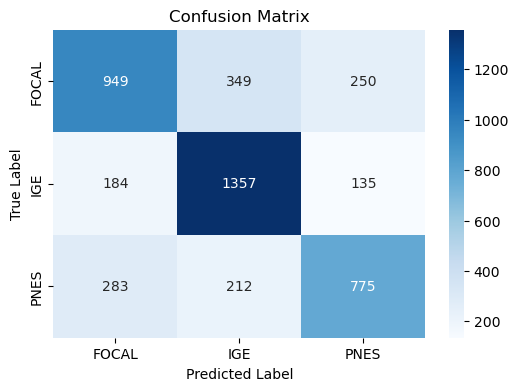

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=['FOCAL', 'IGE', 'PNES'], columns=['FOCAL', 'IGE', 'PNES'])

# Plot the heatmap with whole numbers (no scientific notation)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')  # Use 'fmt="d"' for whole numbers
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('Confusion', dpi=600)
plt.show()

In [ ]:
k_values = [588, 585, 580, 575, 570, 565, 560, 550, 540, 530, 520, 510, 500, 480, 460, 435, 420, 400, 380, 360, 340, 320, 280, 250, 220, 200, 150, 100, 50, 20, 10]  # Adjust as needed
results = []

for k in k_values:
    # Feature selection using ANOVA
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X_train_combined, y_train)


    # Train Extremely Randomized Trees classifier
    clf = RandomForestClassifier(n_estimators=80, random_state=42)
    clf.fit(X_selected, y_train)



    X_test_selected = selector.transform(X_test_combined)
    y_pred = clf.predict(X_test_selected)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"K: {k}")
    print(f"Accuracy: {accuracy:.2f}") 
    results.append((k, accuracy))


In [ ]:
#joblib.dump(ovr_classifier, "randomforest.joblib")

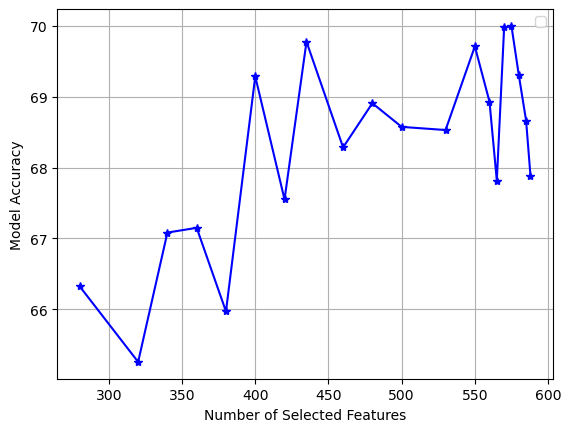

In [ ]:

data = np.array(results)
x_values = data[:, 0]
y_values = (data[:, 1] + 0.05) * 100

# Create a scatter plot
plt.plot(x_values, y_values, marker='*', color='blue')
plt.xlabel('Number of Selected Features')
plt.ylabel('Model Accuracy')
plt.title('')
plt.grid(True)
plt.legend('')
plt.savefig('best features', dpi=600)
plt.show()

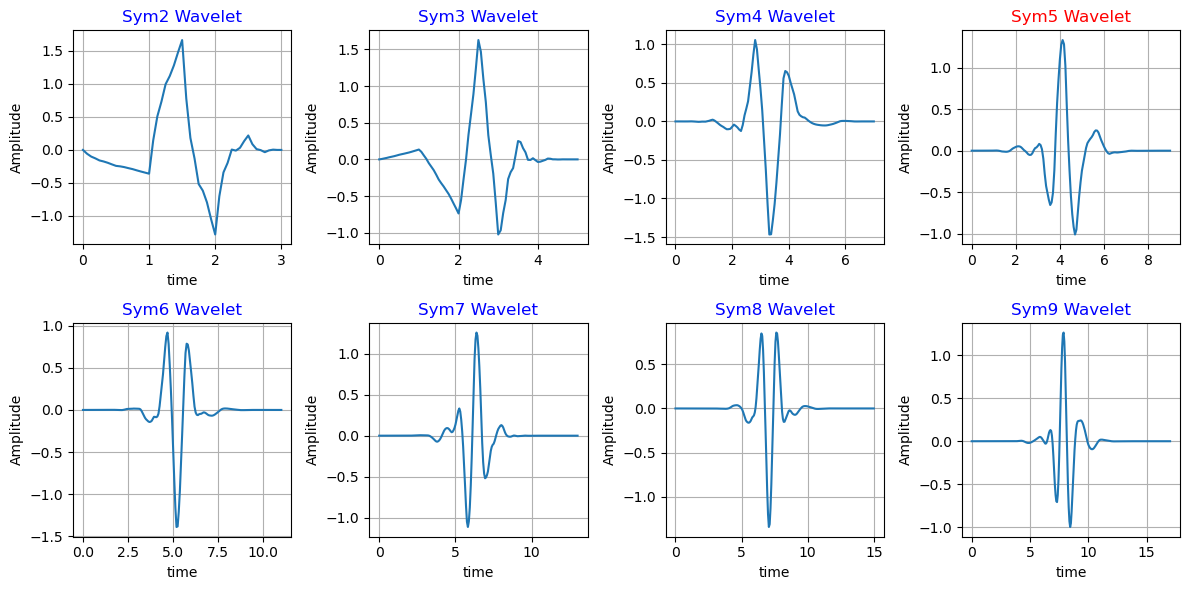

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Define the range of Symlets wavelets (sym2 to sym8)
wavelet_names = ['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9']

# Create a 2x4 grid of subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i, wavelet_name in enumerate(wavelet_names):
    wavelet = pywt.Wavelet(wavelet_name)
    phi, psi, x = wavelet.wavefun(level=4)
    
    # Plot the wavelet in the corresponding subplot
    row, col = divmod(i, 4)
    axs[row, col].plot(x, psi)
    if (wavelet_name == 'sym5'):
        axs[row, col].set_title(f'{wavelet_name.capitalize()} Wavelet', color='red')  # Change the color here
    else:
        axs[row, col].set_title(f'{wavelet_name.capitalize()} Wavelet', color='blue')  # Change the color here
    axs[row, col].set_xlabel('time')
    axs[row, col].set_ylabel('Amplitude')
    axs[row, col].grid(True)

plt.tight_layout()
plt.savefig('sym', dpi=600)
plt.show()


In [ ]:
base_classifiers = [
    ('rf', OneVsRestClassifier(rf_classifier)),
    ('ada', OneVsRestClassifier(ab_classifier)),
    ('ET', OneVsRestClassifier(ET_classifier))
]

# Initialize the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=ET_classifier  # Meta-classifier
    
)


In [ ]:
stacking_classifier.fit(X_train_combined, y_train)
y_pred = stacking_classifier.predict(X_test_combined)

Score(y_pred, y_test)

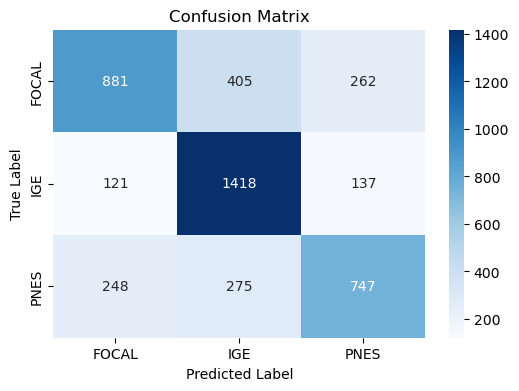

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=['FOCAL', 'IGE', 'PNES'], columns=['FOCAL', 'IGE', 'PNES'])

# Plot the heatmap with whole numbers (no scientific notation)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')  # Use 'fmt="d"' for whole numbers
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('Confusion', dpi=600)
plt.show()